In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

# Algorithms
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

## Quick exploration of the data, and see what attributes contributes to survival

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,RandID
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,9
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,5


In [4]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

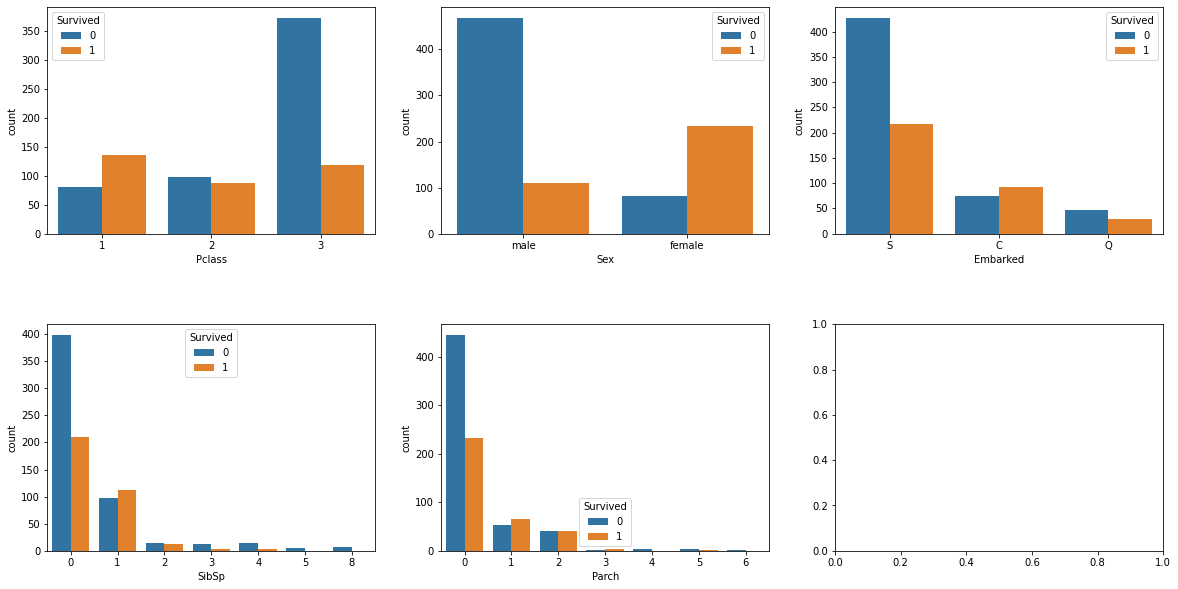

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
sns.countplot(x="Pclass", hue="Survived", data=df, ax=axs[0,0])
sns.countplot(x="Sex", hue="Survived", data=df, ax=axs[0,1])
sns.countplot(x="Embarked", hue="Survived", data=df, ax=axs[0,2])
sns.countplot(x="SibSp", hue="Survived", data=df, ax=axs[1,0])
sns.countplot(x="Parch", hue="Survived", data=df, ax=axs[1,1])

plt.show()

/Users/ronaldleung/Anaconda/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

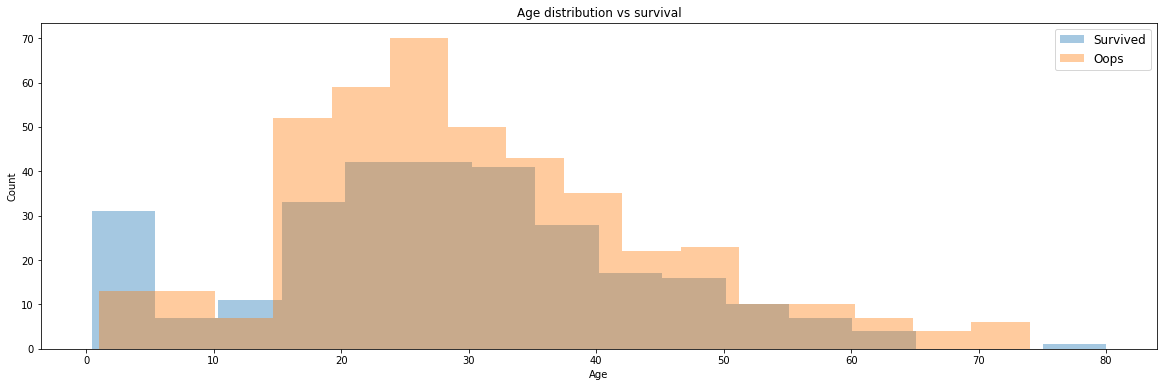

In [6]:
fig = plt.figure(figsize=(20,6))
df_alive = df[df["Survived"] == 1]
sns.distplot(df_alive["Age"],  kde=False, label='Survived')
df_dead = df[df["Survived"] == 0]
sns.distplot(df_dead["Age"],  kde=False, label='Oops')

plt.legend(prop={'size': 12})
plt.title('Age distribution vs survival')
plt.xlabel('Age')
plt.ylabel('Count')

In [7]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

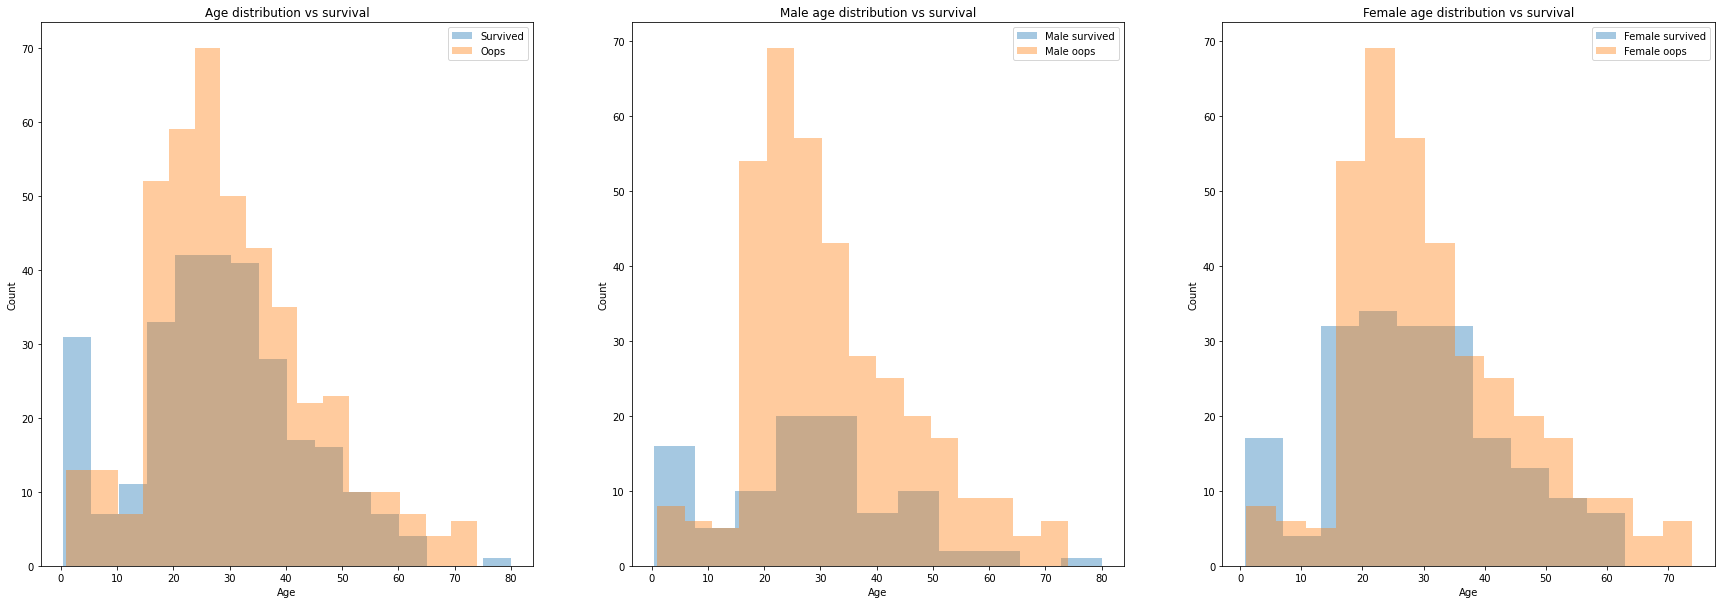

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))
# fig.subplots_adjust(hspace=0.4,wspace=0.2)

#Plot the overall age distribution for age vs survival
df_alive = df[df["Survived"] == 1]
sns.distplot(df_alive["Age"],  kde=False, label='Survived', ax=axs[0])
df_dead = df[df["Survived"] == 0]
sns.distplot(df_dead["Age"],  kde=False, label='Oops', ax=axs[0])
axs[0].set_title("Age distribution vs survival")

#Plot the age distribution for age vs survival for male only
df_alive = df[(df["Survived"] == 1) & (df["Sex"] == "male")]
sns.distplot(df_alive["Age"],  kde=False, label='Male survived', ax=axs[1])
df_dead = df[(df["Survived"] == 0) & (df["Sex"] == "male")]
sns.distplot(df_dead["Age"],  kde=False, label='Male oops', ax=axs[1])
axs[1].set_title("Male age distribution vs survival")

#Plot the age distribution for age vs survival for female only
df_alive = df[(df["Survived"] == 1) & (df["Sex"] == "female")]
sns.distplot(df_alive["Age"],  kde=False, label='Female survived', ax=axs[2])
df_dead = df[(df["Survived"] == 0) & (df["Sex"] == "male")]
sns.distplot(df_dead["Age"],  kde=False, label='Female oops', ax=axs[2])
axs[2].set_title("Female age distribution vs survival")
for i in range(0,3):
    axs[i].set_xlabel("Age", fontsize=10)
    axs[i].set_ylabel("Count", fontsize=10)
    axs[i].legend()

plt.show()

Text(0, 0.5, 'Count')

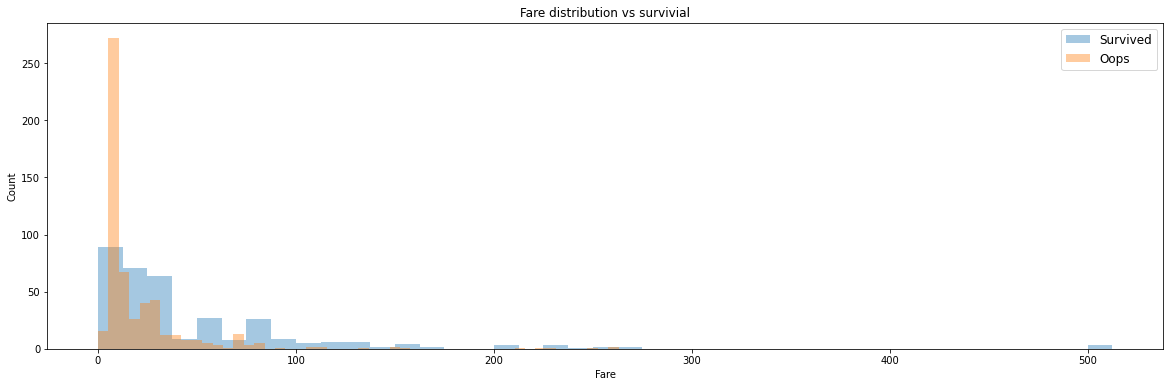

In [9]:
fig = plt.figure(figsize=(20,6))
df_alive = df[df["Survived"] == 1]
sns.distplot(df_alive["Fare"],  kde=False, label='Survived')
df_dead = df[df["Survived"] == 0]
sns.distplot(df_dead["Fare"],  kde=False, label='Oops')

plt.legend(prop={'size': 12})
plt.title('Fare distribution vs survivial')
plt.xlabel('Fare')
plt.ylabel('Count')

### First test in Jupyter. 
#### Just use raw data + one hot encoding. Not doing any cleaning for null or missing data.
#### We will use Pclass, sex, age, sibsp (number of siblings and spouse), parch (number of parents and children), fare, embarked
#### Pclass, sex, embarked, needs to be one hot encoded as those are not numeric. Age, sibsp, and parch are numbers.

In [10]:
df.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [11]:
df_ml = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df_ml["Pclass"] = df_ml["Pclass"].astype(str) 
df_ml.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RandID
0,0,3,male,22.0,1,0,7.2500,S,7
1,1,1,female,38.0,1,0,71.2833,C,5
2,1,3,female,26.0,0,0,7.9250,S,9
3,1,1,female,35.0,1,0,53.1000,S,7
4,0,3,male,35.0,0,0,8.0500,S,5


In [12]:
df_ml.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RandID
0,0,3,male,22.0,1,0,7.2500,S,7
1,1,1,female,38.0,1,0,71.2833,C,5
2,1,3,female,26.0,0,0,7.9250,S,9
3,1,1,female,35.0,1,0,53.1000,S,7
4,0,3,male,35.0,0,0,8.0500,S,5


In [13]:
df_ml.dtypes

Survived      int64
Pclass       object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
RandID        int64
dtype: object

In [14]:
sex_onehot = pd.get_dummies(df_ml[["Sex"]], prefix='Sex')
pclass_onehot = pd.get_dummies(df_ml[["Pclass"]], prefix='Pclass')
embark_onehot = pd.get_dummies(df_ml[["Embarked"]], prefix='Embark')

In [15]:
df_ml = pd.concat([df_ml, sex_onehot], axis=1)
df_ml = pd.concat([df_ml, pclass_onehot], axis=1)
df_ml = pd.concat([df_ml, embark_onehot], axis=1)

In [16]:
df_ml.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RandID,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embark_C,Embark_Q,Embark_S
0,0,3,male,22.0,1,0,7.2500,S,7,0,1,0,0,1,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,5,1,0,1,0,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,9,1,0,0,0,1,0,0,1
3,1,1,female,35.0,1,0,53.1000,S,7,1,0,1,0,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,S,5,0,1,0,0,1,0,0,1


In [17]:
df_ml.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RandID,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embark_C,Embark_Q,Embark_S
886,0,2,male,27.0,0,0,13.00,S,9,0,1,0,1,0,0,0,1
887,1,1,female,19.0,0,0,30.00,S,7,1,0,1,0,0,0,0,1
888,0,3,female,NaN,1,2,23.45,S,8,1,0,0,0,1,0,0,1
889,1,1,male,26.0,0,0,30.00,C,10,0,1,1,0,0,1,0,0
890,0,3,male,32.0,0,0,7.75,Q,7,0,1,0,0,1,0,1,0


#### Basic onehot encoding done. We can now drop the original columns before one hot encoding, and then start the actual maching learning training and evaluation

In [18]:
#Pick 70% of the data as train data, and just use rand id column 1-7
df_ml = df_ml.drop(["Pclass", "Embarked", "Sex"], axis=1)

In [19]:
# Checking if there are still any invalid values, looks like age has some issues. Let's just drop them, you can't really fill in the age.
df_ml.isnull().sum()

Survived        0
Age           177
SibSp           0
Parch           0
Fare            0
RandID          0
Sex_female      0
Sex_male        0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Embark_C        0
Embark_Q        0
Embark_S        0
dtype: int64

In [20]:
df_ml = df_ml.dropna(subset=["Age"])
df_ml.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
RandID        0
Sex_female    0
Sex_male      0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embark_C      0
Embark_Q      0
Embark_S      0
dtype: int64

In [21]:
df_ml.Survived.value_counts()

0    424
1    290
Name: Survived, dtype: int64

In [22]:
df_train = df_ml[df_ml["RandID"] <= 7]
display(df_train.head())
df_train.Survived.value_counts()

,Survived,Age,SibSp,Parch,Fare,RandID,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embark_C,Embark_Q,Embark_S
0,0,22.0,1,0,7.2500,7,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,5,1,0,1,0,0,1,0,0
3,1,35.0,1,0,53.1000,7,1,0,1,0,0,0,0,1
4,0,35.0,0,0,8.0500,5,0,1,0,0,1,0,0,1
8,1,27.0,0,2,11.1333,2,1,0,0,0,1,0,0,1


0    305
1    196
Name: Survived, dtype: int64

In [23]:
df_test = df_ml[df_ml["RandID"] > 7]
display(df_test.head())
df_test.Survived.value_counts()

,Survived,Age,SibSp,Parch,Fare,RandID,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embark_C,Embark_Q,Embark_S
2,1,26.0,0,0,7.9250,9,1,0,0,0,1,0,0,1
6,0,54.0,0,0,51.8625,10,0,1,1,0,0,0,0,1
7,0,2.0,3,1,21.0750,9,0,1,0,0,1,0,0,1
9,1,14.0,1,0,30.0708,8,1,0,0,1,0,1,0,0
10,1,4.0,1,1,16.7000,9,1,0,0,0,1,0,0,1


0    119
1     94
Name: Survived, dtype: int64

In [24]:
x_train = df_train.drop("Survived", axis=1)
x_train = x_train.drop("RandID", axis=1)
y_train = df_train["Survived"]
x_test = df_test.drop("Survived", axis=1)
x_test = x_test.drop("RandID", axis=1)
y_test = df_test["Survived"]

In [25]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
pred = random_forest.predict(x_test)
random_forest.score(x_test, y_test)


0.784037558685446

In [80]:
#Process test data
prdtest_df = pd.read_csv("test.csv")
testPID = pd.DataFrame(prdtest_df["PassengerId"])
prdtest_df = prdtest_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
prdtest_df["Pclass"] = prdtest_df["Pclass"].astype(str) 
sex_onehot = pd.get_dummies(prdtest_df[["Sex"]], prefix='Sex')
pclass_onehot = pd.get_dummies(prdtest_df[["Pclass"]], prefix='Pclass')
embark_onehot = pd.get_dummies(prdtest_df[["Embarked"]], prefix='Embark')
prdtest_df = pd.concat([prdtest_df, sex_onehot], axis=1)
prdtest_df = pd.concat([prdtest_df, pclass_onehot], axis=1)
prdtest_df = pd.concat([prdtest_df, embark_onehot], axis=1)
prdtest_df = prdtest_df.drop(["Pclass", "Embarked", "Sex"], axis=1)

In [81]:
prdtest_df["Age"].isnull().sum()

86

In [82]:
pclass_onehot.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


In [83]:
agemiss_df = prdtest_df[prdtest_df["Age"].isnull()]

In [84]:
agemiss_df.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embark_C,Embark_Q,Embark_S
10,NaN,0,0,7.8958,0,1,0,0,1,0,0,1
22,NaN,0,0,31.6833,1,0,1,0,0,0,0,1
29,NaN,2,0,21.6792,0,1,0,0,1,1,0,0
33,NaN,1,2,23.4500,1,0,0,0,1,0,0,1
36,NaN,0,0,8.0500,1,0,0,0,1,0,0,1


In [85]:
meanAge = prdtest_df["Age"].mean()
meanAge

30.272590361445783

In [86]:
from sklearn.impute import SimpleImputer
myImputer = SimpleImputer()
imputed_df = pd.DataFrame(myImputer.fit_transform(prdtest_df))
imputed_df.columns = prdtest_df.columns
prdtest_df = imputed_df

In [87]:
prdtest_df.loc[22]

Age           30.27259
SibSp          0.00000
Parch          0.00000
Fare          31.68330
Sex_female     1.00000
Sex_male       0.00000
Pclass_1       1.00000
Pclass_2       0.00000
Pclass_3       0.00000
Embark_C       0.00000
Embark_Q       0.00000
Embark_S       1.00000
Name: 22, dtype: float64

In [88]:
x_train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embark_C', 'Embark_Q', 'Embark_S'],
      dtype='object')

In [89]:
prdtest_df.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embark_C', 'Embark_Q', 'Embark_S'],
      dtype='object')

In [92]:
testPID.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [95]:
#Submit test data

pred = random_forest.predict(prdtest_df)
pred_df = pd.DataFrame(pred)
pred_df.columns = ['Survived']
pred_df = pd.concat([testPID, pred_df], axis=1)
pred_df.head()
pred_df.to_csv("random_forest_classifier_submission.csv", index=False)

In [26]:
grad_desc = linear_model.SGDClassifier(max_iter=100, tol=None)
grad_desc.fit(x_train, y_train)
pred = grad_desc.predict(x_test)
grad_desc.score(x_test, y_test)

0.7089201877934272

In [27]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)
logreg.score(x_test, y_test)

/Users/ronaldleung/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7981220657276995